In [2]:
## Making essential imports
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

In [ ]:
## defining a frame for image and mask storage
framObjTrain = {'img' : [],
           'mask' : []
          }

framObjValidation = {'img' : [],
           'mask' : []
          }
framObjTest = {'img' : [],
           'mask' : []
          }
## defining data Loader function
def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 256):
    imgNames = os.listdir(imgPath)
    maskNames = []
    
    ## generating mask names
    for mem in imgNames:
        maskNames.append(re.sub('\.png', '_L.png', mem))
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(imgNames)):
        img = plt.imread(imgAddr + imgNames[i])
        mask = plt.imread(maskAddr + maskNames[i])
        
        img = cv2.resize(img, (shape, shape)) 
        mask = cv2.resize(mask, (shape, shape))
        
        frameObj['img'].append(img)
        frameObj['mask'].append(mask)
        
    return frameObj
        
    
 
    
   

In [ ]:
framObjTrain = LoadData( framObjTrain, imgPath = '/kaggle/input/camvid/CamVid/train', maskPath = '/kaggle/input/camvid/CamVid/train_labels'
         , shape = 128)

In [ ]:
framObjValidation  = LoadData( framObjValidation, imgPath = '/kaggle/input/camvid/CamVid/val', maskPath = '/kaggle/input/camvid/CamVid/val_labels'
         , shape = 128)

In [ ]:
framObjTest  = LoadData( framObjTest, imgPath = '/kaggle/input/camvid/CamVid/test', maskPath = '/kaggle/input/camvid/CamVid/test_labels'
         , shape = 128)

In [ ]:
## displaying data loaded by our function
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][1])
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][1])
plt.show()

## Simple U-Net

In [ ]:
# this block essentially performs 2 convolution

def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x


# Now defining Unet 
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(32, (1, 1), activation = 'softmax')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

## instanctiating model
inputs = tf.keras.layers.Input((128, 128, 3))
model1 = GiveMeUnet(inputs, droupouts= 0.07)
model1.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'] )

In [ ]:
retVal = model1.fit(np.array(framObjTrain['img']),np.array(framObjTrain['mask']), epochs = 500, verbose = 1)

## ATTN _ UNET

In [ ]:
import tensorflow as tf

def attention_gate(F_g, F_l, inter_channels):
    """
    Attention Gate.
    
    Parameters:
    - F_g: Gating signal from the coarser scale.
    - F_l: Feature map from the encoder path.
    - inter_channels: Number of inter channels.
    
    Returns:
    - Attention coefficients applied feature map.
    """
    # Gating signal
    gating = tf.keras.layers.Conv2D(inter_channels, (1, 1), padding='same')(F_g)
    gating = tf.keras.layers.BatchNormalization()(gating)

    # Encoder features
    x = tf.keras.layers.Conv2D(inter_channels, (1, 1), padding='same')(F_l)
    x = tf.keras.layers.BatchNormalization()(x)

    # Combine gating and encoder features
    x = tf.keras.layers.Add()([gating, x])
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(1, (1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('sigmoid')(x)

    # Apply attention coefficients
    return tf.keras.layers.Multiply()([F_l, x])

def Conv2dBlock(inputTensor, numFilters, kernelSize, doBatchNorm):
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                          kernel_initializer = 'he_normal', padding = 'same') (inputTensor)

    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x =tf.keras.layers.Activation('relu')(x)

    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                          kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Activation('relu')(x)

    return x

def GiveMeUnet_attn(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # Encoder Path
    # ... your existing encoder path code ...
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)

    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # Decoder Path with Attention Gates
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    attn6 = attention_gate(u6, c4, numFilters*8)  # Attention Gate
    u6 = tf.keras.layers.concatenate([u6, attn6])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)

    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    

    output = tf.keras.layers.Conv2D(32, (1, 1), activation = 'softmax')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model


inputs = tf.keras.layers.Input((128, 128, 3))
model2 = GiveMeUnet_attn(inputs, droupouts= 0.07)
model2.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'] )

In [ ]:
attnVal = model2.fit(np.array(framObjTrain['img']),np.array(framObjTrain['mask']), epochs = 500, verbose = 1)

In [ ]:
plt.plot(attnVal.history['loss'], label = 'training_loss')
plt.plot(attnVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

## RES_UNET

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50

def Conv2dBlock(inputTensor, numFilters, kernelSize, doBatchNorm):
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x


def upsample_block(x, skip, filters, kernel_size=(3, 3), up_size=(2, 2)):
    """
    Upsampling block with skip connections.
    """
    x = tf.keras.layers.UpSampling2D(size=up_size)(x)
    x = tf.keras.layers.concatenate([x, skip])
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
    return x

def ResNetUNet(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Pre-trained ResNet50 as encoder
    resnet = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
    #[print(i, layer.name) for i, layer in enumerate(resnet.layers)]
    # Encoder - extract skip connections
    s1 = resnet.get_layer(resnet.layers[0].name).output
    s2 = resnet.get_layer('conv1_relu').output
    s3 = resnet.get_layer('conv2_block3_out').output
    s4 = resnet.get_layer('conv3_block4_out').output

    # Bridge
    b1 = resnet.get_layer('conv4_block6_out').output

    # Decoder
    d1 = upsample_block(b1, s4, 512)
    d2 = upsample_block(d1, s3, 256)
    d3 = upsample_block(d2, s2, 128)
    d4 = upsample_block(d3, s1, 64)

    # Additional layers to match the depth of the attention U-Net
    d5 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(d4)
    d6 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(d5)
    # You can add more layers or attention mechanisms here

    # Output
    outputs = tf.keras.layers.Conv2D(32, (1, 1), activation='softmax')(d6)  # Adjust the number of filters

    # Model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Example usage
inputs = (128, 128, 3)
model3 = ResNetUNet(inputs)
model3.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'] )

In [ ]:
RESVal =model3.fit(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), epochs =500,verbose = 1,batch_size=8)

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Input, Multiply
from tensorflow.keras.models import Model

def batchnorm_relu(inputs):
    """ Batch Normalization & ReLU """
    x = BatchNormalization()(inputs)
    x = Activation("relu")(x)
    return x

def residual_block(inputs, num_filters, strides=1):
    """ Convolutional Layers """
    x = batchnorm_relu(inputs)
    x = Conv2D(num_filters, 3, padding="same", strides=strides)(x)
    x = batchnorm_relu(x)
    x = Conv2D(num_filters, 3, padding="same", strides=1)(x)

    """ Shortcut Connection (Identity Mapping) """
    s = Conv2D(num_filters, 1, padding="same", strides=strides)(inputs)

    """ Addition """
    x = x + s
    return x

def attention_gate(F_g, F_l, inter_channels):
    """ Attention Gate """
    # Resizing gating signal to match the size of F_l
    gating_resized = Conv2D(inter_channels, (1, 1), padding='same')(F_g)
    gating_resized = BatchNormalization()(gating_resized)
    gating_resized = Activation('relu')(gating_resized)
    gating_resized = UpSampling2D(size=(F_l.shape[1] // gating_resized.shape[1], 
                                        F_l.shape[2] // gating_resized.shape[2]))(gating_resized)

    # Processing encoder features
    x = Conv2D(inter_channels, (1, 1), padding='same')(F_l)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Combine gating and encoder features
    x = Multiply()([gating_resized, x])

    return x

def decoder_block(inputs, skip_features, num_filters):
    """ Decoder Block with Attention Gate """
    x = UpSampling2D((2, 2))(inputs)

    # Applying attention gate
    attn = attention_gate(x, skip_features, num_filters)
    x = Concatenate()([x, attn])
    x = residual_block(x, num_filters, strides=1)
    return x

def build_resunet_attn(input_shape):
    """ RESUNET Architecture """
    inputs = Input(input_shape)

    """ Endoder 1 """
    x = Conv2D(64, 3, padding="same", strides=1)(inputs)
    x = batchnorm_relu(x)
    x = Conv2D(64, 3, padding="same", strides=1)(x)
    s = Conv2D(64, 1, padding="same")(inputs)
    s1 = x + s

    """ Encoder 2, 3 """
    s2 = residual_block(s1, 128, strides=2)
    s3 = residual_block(s2, 256, strides=2)

    """ Bridge """
    b = residual_block(s3, 512, strides=2)

    """ Decoder 1, 2, 3 """
    x = decoder_block(b, s3, 256)
    x = decoder_block(x, s2, 128)
    x = decoder_block(x, s1, 64)

    """ Classifier """
    outputs = Conv2D(3, (1,1), padding="same", activation="sigmoid")(x)

    """ Model """
    model = Model(inputs, outputs, name="RESUNET")

    return model

# Example usage
inputs = (128, 128, 3)
model4 = build_resunet_attn(inputs)
model4.compile(optimizer = 'Adam', loss = 'mean', metrics = ['accuracy'] )

In [ ]:
RESAttnVal =model4.fit(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), epochs = 500, verbose = 1,batch_size=8)

In [ ]:
import pandas as pd

# Assuming RESAttnVal.history is a dictionary containing 'loss' and 'accuracy' keys
data = {
    'training_loss': RESAttnVal.history['loss'],
    'training_accuracy': RESAttnVal.history['accuracy']
}

# Creating a DataFrame
df = pd.DataFrame(data)

print(df)


## Inference

In [6]:
def LoadData_kitti( frameObj = None, imgPath = None, shape = 256):
    imgNames = os.listdir(imgPath)
    maskNames = []   
    ## generating mask names
   
    imgAddr = imgPath + '/'
  
    
    for i in range (len(imgNames)):
        img = plt.imread(imgAddr + imgNames[i])
    
        img = cv2.resize(img, (shape, shape)) 
   
        
        frameObj['img'].append(img)

        
    return frameObj

In [ ]:
## function for getting 16 predictions
def predict16 (valMap, model, shape = 256):
    img = valMap['img']
    imgProc = np.array(img)
    
    predictions = (model.predict(imgProc))
    predictions = np.argmax(predictions,axis=3)
    return predictions, imgProc
 
    
    

In [13]:
def Plotter(img, predMask):
    plt.figure(figsize=(7,7))
    
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title('image')
    
    plt.subplot(1,2,2)
    plt.imshow(predMask)
    plt.title('Predicted Mask')

In [ ]:
framObj = {'img':[]}
framObj= LoadData_kitti( framObj, imgPath = '/kaggle/input/idd-semantic-segmentation/idd20kII/images/validation'
         , shape = 128)

In [9]:
sixteenPrediction, actuals= predict16(framObj, model1)

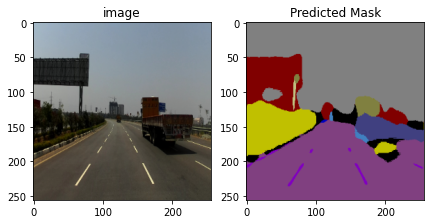

In [50]:
Plotter(sixteenPrediction[0],actuals[0])

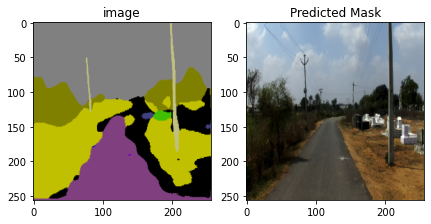

In [51]:
Plotter(actuals[1], sixteenPrediction[1])

In [11]:
import os
import zipfile
import matplotlib.pyplot as plt
file_name ="random_images_unet_attn"
# Create a directory to store images
os.makedirs(file_name, exist_ok=True)

# Save images in the folder
for i in range(2):

    plt.imsave(file_name + f'/random_test_predictions_U{i}_UNET_attn.jpg', sixteenPrediction[i])        
    plt.imsave(file_name + f'/random_test_actual_U{i}_UNET_attn.jpg', actuals[i]) 

# Create a ZIP file
zip_filename = file_name + ".zip"
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for root, _, files in os.walk(file_name):
        for file in files:
            zipf.write(os.path.join(root, file), arcname=file)

print("ZIP file created successfully. You can now download it.")


ZIP file created successfully. You can now download it.


In [12]:
sixteenPrediction, actuals = predict16(framObj, model2)

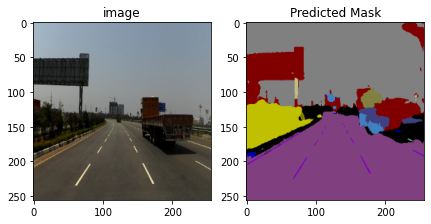

In [48]:
Plotter(sixteenPrediction[0],actuals[0])

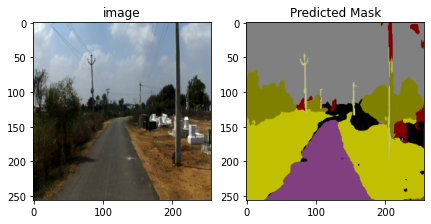

In [47]:
Plotter(sixteenPrediction[1],actuals[1])

In [13]:
import os
import zipfile
import matplotlib.pyplot as plt
file_name ="random_images_unet"
# Create a directory to store images
os.makedirs(file_name, exist_ok=True)

# Save images in the folder
for i in range(100):

    plt.imsave(file_name + f'/random_test_predictions_U{i}_UNET.jpg', sixteenPrediction[i])        
    plt.imsave(file_name + f'/random_test_actual_U{i}_UNET.jpg', actuals[i]) 

# Create a ZIP file
zip_filename = file_name + ".zip"
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for root, _, files in os.walk(file_name):
        for file in files:
            zipf.write(os.path.join(root, file), arcname=file)

print("ZIP file created successfully. You can now download it.")


ZIP file created successfully. You can now download it.


In [14]:
sixteenPrediction, actuals= predict16(framObj, model3)

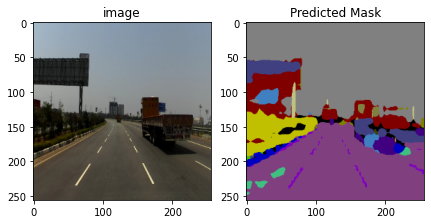

In [43]:
Plotter(sixteenPrediction[0],actuals[0])

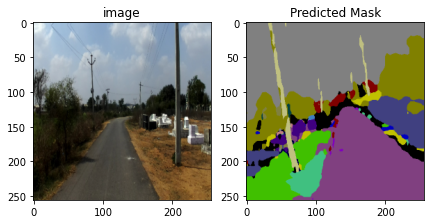

In [44]:
Plotter(sixteenPrediction[1],actuals[1])

In [15]:
import os
import zipfile
import matplotlib.pyplot as plt
file_name ="random_images_resunet"
# Create a directory to store images
os.makedirs(file_name, exist_ok=True)

# Save images in the folder
for i in range(100):

    plt.imsave(file_name + f'/random_test_predictions_U{i}_Resunet.jpg', sixteenPrediction[i])        
    plt.imsave(file_name + f'/random_test_actual_U{i}_Resunet.jpg', actuals[i]) 

# Create a ZIP file
zip_filename = file_name + ".zip"
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for root, _, files in os.walk(file_name):
        for file in files:
            zipf.write(os.path.join(root, file), arcname=file)

print("ZIP file created successfully. You can now download it.")


ZIP file created successfully. You can now download it.


In [16]:
sixteenPrediction, actuals= predict16(framObj, model4)

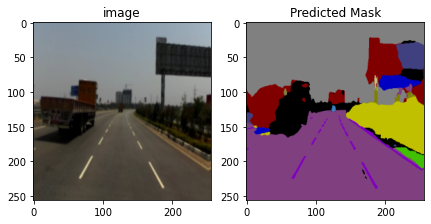

In [39]:
Plotter(sixteenPrediction[0],actuals[0])

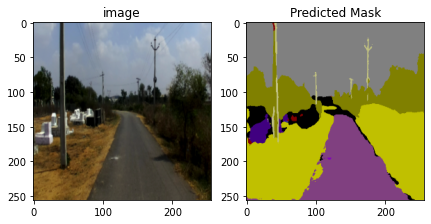

In [38]:
Plotter(sixteenPrediction[1],actuals[1])

In [18]:
import os
import zipfile
import matplotlib.pyplot as plt
file_name ="IDD_images_resunet_attn"
# Create a directory to store images
os.makedirs(file_name, exist_ok=True)

# Save images in the folder
for i in range(2):

    plt.imsave(file_name + f'/IDD_test_predictions{i}_RESUNET_attn.jpg', sixteenPrediction[i])        
    plt.imsave(file_name + f'/IDD_test_actual{i}_RESUNET_attn.jpg', actuals[i]) 

# Create a ZIP file
zip_filename = file_name + ".zip"
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for root, _, files in os.walk(file_name):
        for file in files:
            zipf.write(os.path.join(root, file), arcname=file)

print("ZIP file created successfully. You can now download it.")


ZIP file created successfully. You can now download it.
